In [3]:
#     API Quandl
#     Data cleanup
#     Materials = XLB
#     Real Estate = RWR
#     Technology = XLK
#     S&P500 = SPY

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os
import seaborn as sns
from dotenv import load_dotenv

%matplotlib inline

In [5]:
#QUANDL Data retrieval

#Load quandl api_key
load_dotenv()

api_key = os.getenv("QUANDL_API_KEY")
type(api_key)



str

In [6]:
#Create request url to access quandl to get prices for XLB, S&P Materials Sector ETF

#request_url = "https://www.quandl.com/api/v3/datasets/WIKI/XLB.json?api_key="
request_url = "https://www.quandl.com/api/v3/datasets/WIKI/RWR/data.csv?api_key="

# Concatenate request_url and api_key. Store as new variable
request_url_api = request_url + api_key


In [7]:
# Execute get request, this returned error, XLB, RWR, and XLK not in free wiki dataset.

response_data = requests.get(request_url_api)
response_data.content

b'code,message\nQECx02,You have submitted an incorrect Quandl code. Please check your Quandl codes and try again.\n'

In [8]:
#Try ALPACA data retrieval next
load_dotenv()

APCA_API_KEY_ID = os.getenv("APCA_API_KEY_ID")
APCA_SECRET_KEY = os.getenv("APCA_SECRET_KEY")

api = tradeapi.REST(APCA_API_KEY_ID, APCA_SECRET_KEY, api_version='v2')

type(APCA_API_KEY_ID)


str

In [9]:
#Use alpha vantage to get historic quotes for XLB,XLK,RWR. This goes back 20 years.

xlb_df = api.alpha_vantage.historic_quotes('XLB', adjusted=True, output_format='pandas')
#xlb_df.head()

xlk_df = api.alpha_vantage.historic_quotes('XLK', adjusted=True, output_format='pandas')
# xlk_df.tail()

rwr_df = api.alpha_vantage.historic_quotes('RWR', adjusted=True, output_format='pandas')
#rwr_df.head()

#Use alpha vantage to get historic quotes for S&P500. Will need this later.

spy_df = api.alpha_vantage.historic_quotes('SPY', adjusted=True, output_format='pandas')



#CODE BELOW WAS FIRST ATTEMPT BUT ONLY GETS 1000 TRADING DAYS:

# # Get daily price data for XLB over the last 1000 trading days. Max alpaca would allow.
# #download direct into dataframe

# barset = api.get_barset('XLB', 'day', limit=1000).df
# xlb_bars_df = barset['XLB']
# xlb_bars_df.head()
# xlb_bars_df.tail()

# Get daily price data for XLK over the last 1000 trading days. Max alpaca would allow.

# barset = api.get_barset('XLK', 'day', limit=1000).df
# xlk_bars_df = barset['XLK']
# xlk_bars_df.head()
# xlk_bars_df.tail()

# # Get daily price data for RWR over the last 1000 trading days. Max alpaca would allow.

# barset = api.get_barset('RWR', 'day', limit=1000).df
# rwr_bars_df = barset['RWR']
# rwr_bars_df.head()
# rwr_bars_df.tail()





In [11]:
spy_df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2020-04-29,291.53,294.88,290.41,293.21,293.21,118066585.0,0.0,1.0
2020-04-28,291.02,291.40,285.40,285.73,285.73,104797847.0,0.0,1.0
2020-04-27,285.12,288.27,284.62,287.05,287.05,77516422.0,0.0,1.0
2020-04-24,280.73,283.70,278.50,282.97,282.97,85042563.0,0.0,1.0
2020-04-23,280.49,283.94,278.75,279.08,279.08,103685412.0,0.0,1.0


In [12]:
#DATA CLEANUP

#Select the one column we need,  "adjusted close", and drop the others

xlb_df = xlb_df['5. adjusted close']
xlb_df.head()

xlk_df = xlk_df['5. adjusted close']
xlk_df.head()

rwr_df = rwr_df['5. adjusted close']
rwr_df.head()

spy_df = spy_df['5. adjusted close']
spy_df.head()

#Use concat to put the data in one dataframe
concat_df = pd.concat([xlb_df, xlk_df, rwr_df, spy_df], axis = "columns", join = "inner")
concat_df.head()



,5. adjusted close,5. adjusted close,5. adjusted close,5. adjusted close
date,,,,
2020-04-29,53.47,91.82,79.10,293.21
2020-04-28,52.14,88.20,77.38,285.73
2020-04-27,51.19,89.39,76.08,287.05
2020-04-24,49.86,88.63,73.25,282.97
2020-04-23,49.09,86.79,72.68,279.08


In [13]:
#Change column names to avoid confusion
columns = ['XLB close', 'XLK close', 'RWR close', 'SPY close']
concat_df.columns = columns
concat_df.head()

,XLB close,XLK close,RWR close,SPY close
date,,,,
2020-04-29,53.47,91.82,79.10,293.21
2020-04-28,52.14,88.20,77.38,285.73
2020-04-27,51.19,89.39,76.08,287.05
2020-04-24,49.86,88.63,73.25,282.97
2020-04-23,49.09,86.79,72.68,279.08


In [14]:
#Sort earliest to latest so that .pct_change() function works right

concat_df.sort_index(inplace=True, ascending=True)
concat_df.head()


,XLB close,XLK close,RWR close,SPY close
date,,,,
2001-08-27,14.5697,19.3468,19.2651,82.1301
2001-08-28,14.4324,18.8107,19.2651,80.9499
2001-08-29,14.2494,18.4533,18.8996,80.1862
2001-08-30,14.1971,17.7384,18.8082,78.6589
2001-08-31,14.3213,17.8861,18.7625,79.2837


In [15]:
#add another column to get daily returns of XLB
daily_returns_xlb = concat_df["XLB close"].pct_change()
concat_df['XLB_return']= daily_returns_xlb 

#add another column to get daily returns of XLK
daily_returns_xlk = concat_df['XLK close'].pct_change()
concat_df['XLK_return']= daily_returns_xlk 

#add another column to get daily returns of RWR
daily_returns_rwr = concat_df['RWR close'].pct_change()
concat_df['RWR_return']= daily_returns_rwr 

#add another column to get daily returns of SPY
daily_returns_spy = concat_df['SPY close'].pct_change()
concat_df['SPY_return']= daily_returns_spy 


concat_df.head()


,XLB close,XLK close,RWR close,SPY close,XLB_return,XLK_return,RWR_return,SPY_return
date,,,,,,,,
2001-08-27,14.5697,19.3468,19.2651,82.1301,NaN,NaN,NaN,NaN
2001-08-28,14.4324,18.8107,19.2651,80.9499,-0.009424,-0.027710,0.000000,-0.014370
2001-08-29,14.2494,18.4533,18.8996,80.1862,-0.012680,-0.019000,-0.018972,-0.009434
2001-08-30,14.1971,17.7384,18.8082,78.6589,-0.003670,-0.038741,-0.004836,-0.019047
2001-08-31,14.3213,17.8861,18.7625,79.2837,0.008748,0.008327,-0.002430,0.007943


In [16]:
#check for nulls

concat_df.isnull().sum()

XLB close     0
XLK close     0
RWR close     0
SPY close     0
XLB_return    1
XLK_return    1
RWR_return    1
SPY_return    1
dtype: int64

In [17]:
# Drop nulls
concat_df.dropna(inplace=True)

#count nulls again
concat_df.isnull().sum()

XLB close     0
XLK close     0
RWR close     0
SPY close     0
XLB_return    0
XLK_return    0
RWR_return    0
SPY_return    0
dtype: int64

In [18]:
# Checking for duplicate rows
concat_df.duplicated()

date
2001-08-28    False
2001-08-29    False
2001-08-30    False
2001-08-31    False
2001-09-04    False
              ...  
2020-04-23    False
2020-04-24    False
2020-04-27    False
2020-04-28    False
2020-04-29    False
Length: 4696, dtype: bool

In [19]:
# drop duplicates
concat_df.drop_duplicates(inplace=True)

In [20]:
#Check datatypes

concat_df.dtypes

XLB close     float64
XLK close     float64
RWR close     float64
SPY close     float64
XLB_return    float64
XLK_return    float64
RWR_return    float64
SPY_return    float64
dtype: object

In [21]:
#check counts
concat_df.count()

XLB close     4696
XLK close     4696
RWR close     4696
SPY close     4696
XLB_return    4696
XLK_return    4696
RWR_return    4696
SPY_return    4696
dtype: int64

In [22]:
#use describe to explore data
concat_df.describe()

,XLB close,XLK close,RWR close,SPY close,XLB_return,XLK_return,RWR_return,SPY_return
count,4696.000000,4696.000000,4696.000000,4696.000000,4696.000000,4696.000000,4696.000000,4696.000000
mean,32.466929,30.800687,53.338909,140.107471,0.000392,0.000440,0.000480,0.000347
std,13.544820,20.072061,23.917871,69.553480,0.015137,0.014746,0.018884,0.012346
min,11.161600,8.997400,15.299700,54.152900,-0.124649,-0.138140,-0.208544,-0.109423
25%,20.762550,16.709625,33.190925,87.501275,-0.006595,-0.005679,-0.005942,-0.004153
50%,30.479050,21.595850,49.618350,110.013300,0.000829,0.000939,0.000841,0.000659
75%,43.478000,39.176675,75.253575,188.087125,0.008203,0.006926,0.007450,0.005637
max,61.111600,102.250500,106.602100,336.274200,0.117601,0.134921,0.174806,0.139609


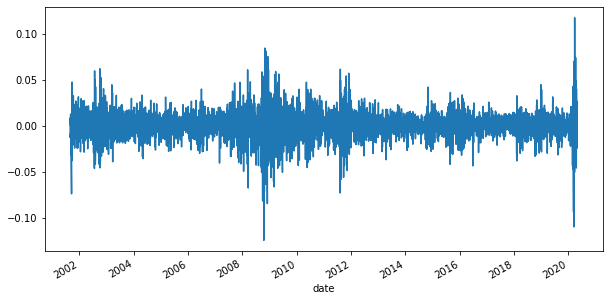

In [23]:
#plot daily returns of XLB

#concat_df['XLB_return'].plot(figsize=(10,5))
daily_returns_xlb.plot(figsize=(10,5))

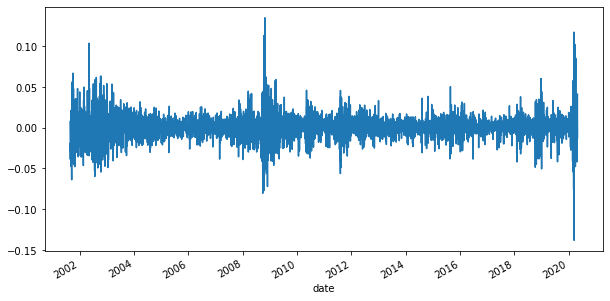

In [24]:
#plot daily returns of XLK

daily_returns_xlk.plot(figsize=(10,5))

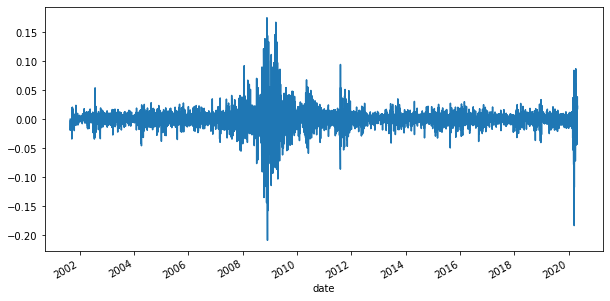

In [25]:
#plot daily returns of RWR

daily_returns_rwr.plot(figsize=(10,5))

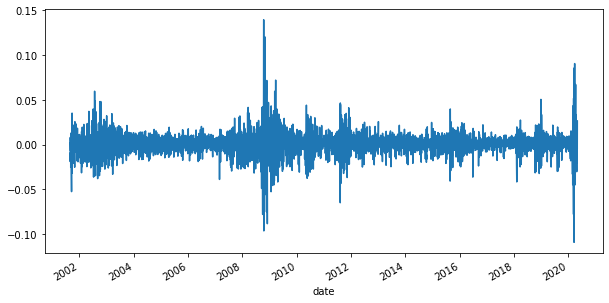

In [26]:
#plot daily returns of SPY

daily_returns_spy.plot(figsize=(10,5))

In [27]:
# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_xlb = (1 + concat_df['XLB_return']).cumprod()
cumulative_returns_xlk = (1 + concat_df['XLK_return']).cumprod()
cumulative_returns_rwr = (1 + concat_df['RWR_return']).cumprod()
cumulative_returns_spy = (1 + concat_df['SPY_return']).cumprod()

cumulative_returns_xlb.head()

date
2001-08-28    0.990576
2001-08-29    0.978016
2001-08-30    0.974426
2001-08-31    0.982951
2001-09-04    0.982951
Name: XLB_return, dtype: float64

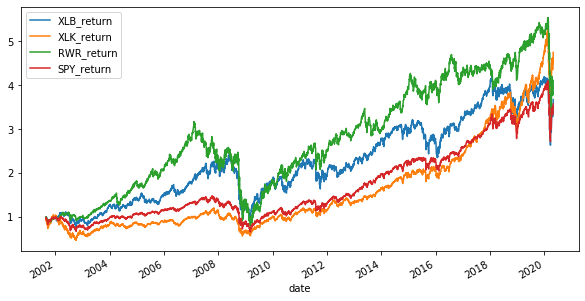

In [28]:
#plot cumulative returns

cumulative_returns_xlb.plot(figsize=(10,5),legend = True)
cumulative_returns_xlk.plot(figsize=(10,5),legend = True)
cumulative_returns_rwr.plot(figsize=(10,5),legend=True)
cumulative_returns_spy.plot(figsize=(10,5),legend=True)


In [29]:
# Calculate Standard Deviations for each sector
xlb_std = concat_df['XLB_return'].std()
print(f' XLB standard deviation is {xlb_std}')


xlk_std = concat_df['XLK_return'].std()
print(f' XLK standard deviation is {xlk_std}')

rwr_std = concat_df['RWR_return'].std()
print(f' RWR standard deviation is {rwr_std}')

spy_std = concat_df['SPY_return'].std()
print(f' SPY standard deviation is {spy_std}')


# Identify the sector with highest standard deviation (riskiest)
sectors = [xlb_std, xlk_std, rwr_std, spy_std]
sectors.sort()
print(sectors)

 XLB standard deviation is 0.01513730380343087
 XLK standard deviation is 0.01474639293043079
 RWR standard deviation is 0.018884423554688997
 SPY standard deviation is 0.012345520413289238
[0.012345520413289238, 0.01474639293043079, 0.01513730380343087, 0.018884423554688997]


In [30]:
# Calculate the annualized standard deviation (252 trading days) for each sector
annualized_xlb_std = xlb_std * np.sqrt(252)
annualized_xlb_std

annualized_xlk_std = xlk_std * np.sqrt(252)
annualized_xlk_std

annualized_rwr_std = rwr_std * np.sqrt(252)
annualized_rwr_std

annualized_spy_std = spy_std * np.sqrt(252)
annualized_spy_std


0.195979060915408

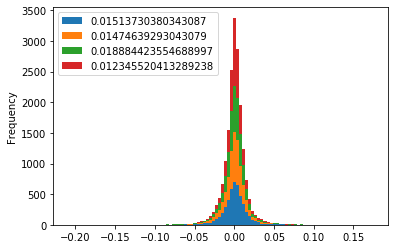

In [31]:
#Plot

sectors_std = pd.DataFrame({
    xlb_std: concat_df['XLB_return'],
    xlk_std: concat_df['XLK_return'],
    rwr_std: concat_df['RWR_return'],
    spy_std: concat_df['SPY_return']
})

sectors_std.plot.hist(stacked=True, bins=100)

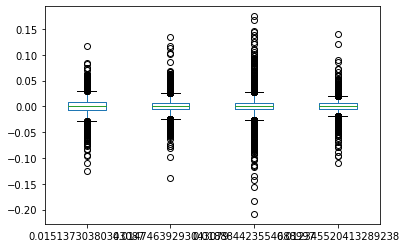

In [32]:
# Plot box plot
sectors_std.plot.box()

In [33]:
# Calculate Sharpe Ratios for the sectors

XLB_sharpe_ratio = (concat_df['XLB_return'].mean() * 252) / (concat_df['XLB_return'].std() * np.sqrt(252))

XLK_sharpe_ratio = (concat_df['XLK_return'].mean() * 252) / (concat_df['XLK_return'].std() * np.sqrt(252))

RWR_sharpe_ratio = (concat_df['RWR_return'].mean() * 252) / (concat_df['RWR_return'].std() * np.sqrt(252))

SPY_sharpe_ratio = (concat_df['SPY_return'].mean() * 252) / (concat_df['SPY_return'].std() * np.sqrt(252))

print(f" XLB: {XLB_sharpe_ratio}, XLK: {XLK_sharpe_ratio}, RWR:{RWR_sharpe_ratio}, SPY: {SPY_sharpe_ratio}")





 XLB: 0.411036703053281, XLK: 0.4739606273102433, RWR:0.4034346952199597, SPY: 0.44655436353367256


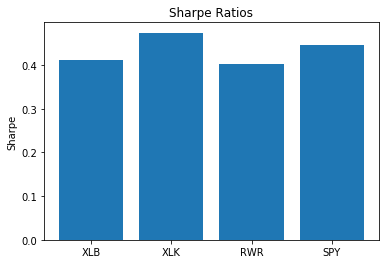

In [34]:
#Plot the sharpe ratios

objects = ('XLB', 'XLK', 'RWR', 'SPY')
y_pos = np.arange(len(objects))
sharpe = [XLB_sharpe_ratio,XLK_sharpe_ratio,RWR_sharpe_ratio, SPY_sharpe_ratio]

plt.bar(y_pos, sharpe, align='center')
plt.xticks(y_pos, objects)
plt.ylabel('Sharpe')
plt.title('Sharpe Ratios')

plt.show()

In [35]:
# Concat returns into one DataFrame
returns_only_df = pd.concat([daily_returns_xlb, daily_returns_xlk, daily_returns_rwr , daily_returns_spy], axis='columns', join='inner')
returns_only_df.head()

#Fix column names
columns = ['XLB_return', 'XLK_return', 'RWR_return', 'SPY_return']
returns_only_df.columns = columns
returns_only_df.head()

# Drop nulls
returns_only_df.dropna(inplace=True)

#count nulls 
returns_only_df.isnull().sum()






XLB_return    0
XLK_return    0
RWR_return    0
SPY_return    0
dtype: int64

In [36]:
#Check correlation

correlation = returns_only_df.corr()
correlation

,XLB_return,XLK_return,RWR_return,SPY_return
XLB_return,1.000000,0.729281,0.623023,0.844522
XLK_return,0.729281,1.000000,0.559509,0.894550
RWR_return,0.623023,0.559509,1.000000,0.700491
SPY_return,0.844522,0.894550,0.700491,1.000000


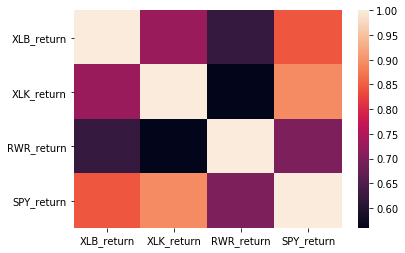

In [37]:
# Create a heatmap from the correlation values
sns.heatmap(correlation)

In [38]:
#BETA CALCULATION XLB and SPY

# Calculate covariance of XLB vs. S&P 500
covariance = returns_only_df['XLB_return'].cov(returns_only_df['SPY_return'])
covariance

# Calculate variance of S&P 500 returns
variance = returns_only_df['SPY_return'].var()
variance

# Calculate beta of XLB
XLB_beta = covariance / variance
XLB_beta

1.035499685297422

In [39]:
#BETA CALCULATION XLK and SPY

# Calculate covariance of XLK vs. S&P 500
covariance = returns_only_df['XLK_return'].cov(returns_only_df['SPY_return'])
covariance

# Calculate variance of S&P 500 returns
variance = returns_only_df['SPY_return'].var()
variance

# Calculate beta of XLK
XLK_beta = covariance / variance
XLK_beta

1.0685156693289222

In [40]:
#BETA CALCULATION RWR and SPY

# Calculate covariance of RWR vs. S&P 500
covariance = returns_only_df['RWR_return'].cov(returns_only_df['SPY_return'])
covariance

# Calculate variance of S&P 500 returns
variance = returns_only_df['SPY_return'].var()
variance

# Calculate beta of RWR
RWR_beta = covariance / variance
RWR_beta

1.071512379028517

A 10,000 investment in XLB would have grown to 36699.4516016118


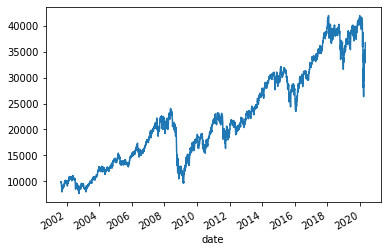

In [41]:
# Plot the returns of XLB in terms of money
initial_investment = 10000
cumulative_profit_xlb = initial_investment * cumulative_returns_xlb
print(f'A 10,000 investment in XLB would have grown to {cumulative_profit_xlb[-1]}')
cumulative_profit_xlb.plot()

A 10,000 investment in XLK would have grown to 47460.045072053195


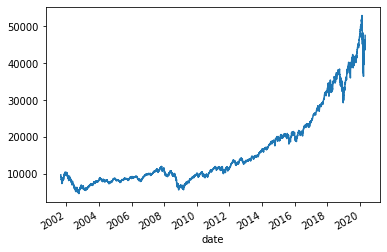

In [42]:
# Plot the returns of XLK in terms of money
initial_investment = 10000
cumulative_profit_xlk = initial_investment * cumulative_returns_xlk
print(f'A 10,000 investment in XLK would have grown to {cumulative_profit_xlk[-1]}')
cumulative_profit_xlk.plot()

A 10,000 investment in RWR would have grown to 41058.702005180334


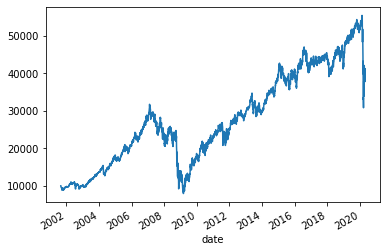

In [43]:
# Plot the returns of RWR in terms of money
initial_investment = 10000
cumulative_profit_rwr = initial_investment * cumulative_returns_rwr
print(f'A 10,000 investment in RWR would have grown to {cumulative_profit_rwr[-1]}')
cumulative_profit_rwr.plot()

A 10,000 investment in SPY would have grown to 35700.674904815576


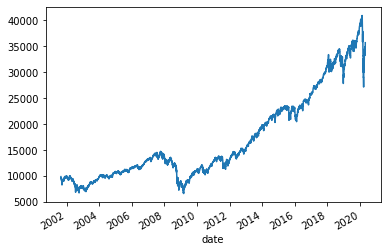

In [44]:
# Plot the returns of SPY in terms of money
initial_investment = 10000
cumulative_profit_spy = initial_investment * cumulative_returns_spy
print(f'A 10,000 investment in SPY would have grown to {cumulative_profit_spy[-1]}')
cumulative_profit_spy.plot()

In [80]:
#START MONTE CARLO ANALYSIS (XLB)

#check concat_df
concat_df.head()


,XLB close,XLK close,RWR close,SPY close,XLB_return,XLK_return,RWR_return,SPY_return
date,,,,,,,,
2001-08-28,14.4324,18.8107,19.2651,80.9499,-0.009424,-0.027710,0.000000,-0.014370
2001-08-29,14.2494,18.4533,18.8996,80.1862,-0.012680,-0.019000,-0.018972,-0.009434
2001-08-30,14.1971,17.7384,18.8082,78.6589,-0.003670,-0.038741,-0.004836,-0.019047
2001-08-31,14.3213,17.8861,18.7625,79.2837,0.008748,0.008327,-0.002430,0.007943
2001-09-04,14.3213,17.4976,18.7321,78.7283,0.000000,-0.021721,-0.001620,-0.007005


In [81]:
# Calculate the mean of daily returns for XLB
avg_daily_return_xlb = concat_df.mean()['XLB_return']
print(f"The average daily return of XLB is {avg_daily_return_xlb}")


# Calculate the mean of daily returns for RWR
avg_daily_return_rwr = concat_df.mean()['RWR_return']
print(f"The average daily return of RWR is {avg_daily_return_rwr}")

# Calculate the mean of daily returns for SPY
avg_daily_return_spy = concat_df.mean()['SPY_return']
print(f"The average daily return of SPY is {avg_daily_return_spy}")

# Standard deviation was calculated previously - xlb_std, xlk_std, rwr_std, spy_std

The average daily return of XLB is 0.00039194836783900956
The average daily return of XLK is 0.0004402788232994087
The average daily return of RWR is 0.00047992868347888543
The average daily return of SPY is 0.00034728295560717014


In [82]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLB from DataFrame

num_trading_days = 252*2
XLB_last_price = concat_df['XLB close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_XLB_df = pd.DataFrame()




In [85]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_XLB_prices = [XLB_last_price]
    simulated_XLB_prices

    # Simulate the returns for 504 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_XLB_prices[-1] * (1 + np.random.normal(avg_daily_return_xlb, xlb_std))
        # Append the simulated price to the list
        simulated_XLB_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_XLB_df[f"Simulation {n+1}"] = pd.Series(simulated_XLB_prices)

simulated_prices_XLB_df.head()



,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,...,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000,53.470000
1,54.382747,52.542079,52.660196,53.494187,54.171327,55.435369,53.330184,53.823793,53.579261,53.286210,...,53.381227,53.224128,53.318245,55.223875,52.760145,53.561559,53.026538,54.518335,53.880569,53.425075
2,55.064974,54.094303,51.878339,53.348614,53.627393,55.781983,51.555987,54.637044,54.420571,54.013355,...,52.577086,53.254879,53.723147,56.491775,52.747087,52.838293,53.575521,54.672261,53.738536,52.505425
3,56.043765,54.516637,51.418030,52.570442,53.914238,55.493515,50.531282,54.256640,54.481397,53.947330,...,53.313274,53.793721,55.008804,55.722109,50.889736,54.187352,54.396675,55.173994,55.536288,52.288454
4,55.403779,55.259812,50.008445,53.211486,54.420281,55.239884,49.452638,54.304199,55.350189,53.257565,...,52.613286,52.693083,54.729914,55.925389,50.480487,54.003934,54.370986,55.039418,54.516666,51.530704


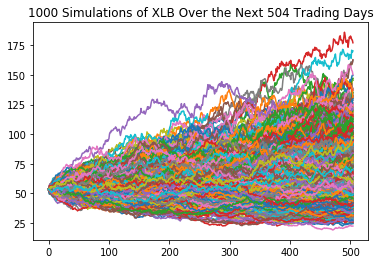

In [86]:
#Plot 1000 simulations of 504 trading days
plot_title = f"{n+1} Simulations of XLB Over the Next 504 Trading Days"
simulated_prices_XLB_df.plot(legend=None, title=plot_title)

In [87]:
# Select the last row (price of each simulation on the 504th trading day)
simulated_ending_prices_XLB = simulated_prices_XLB_df.iloc[-1, :]
simulated_ending_prices_XLB.head()

Simulation 1    77.926341
Simulation 2    83.528673
Simulation 3    56.670378
Simulation 4    90.423968
Simulation 5    90.221831
Name: 504, dtype: float64

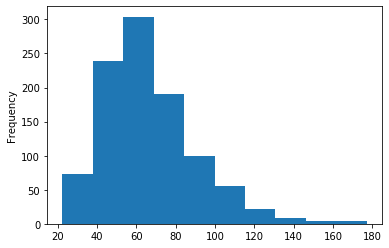

In [88]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_XLB.plot(kind='hist')

In [89]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_XLB.quantile(q=[0.025, 0.975])
confidence_interval

0.025     31.726510
0.975    123.710379
Name: 504, dtype: float64

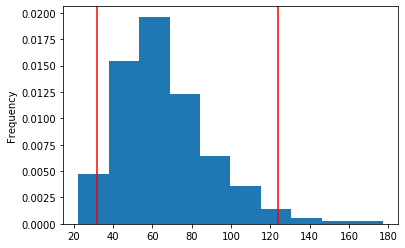

In [90]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_XLB.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [93]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - XLB_last_price) / XLB_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - XLB_last_price) / XLB_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in XLB"
      f" over the next 504 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in XLB over the next 504 trading days will end within in the range of $5933.52 and $23136.41


In [94]:
#START MONTE CARLO ANALYSIS XLK

# Calculate the mean of daily returns for XLK
avg_daily_return_xlk = concat_df.mean()['XLK_return']
print(f"The average daily return of XLK is {avg_daily_return_xlk}")

The average daily return of XLK is 0.0004402788232994087


In [95]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLK from DataFrame

num_trading_days = 252*2
XLK_last_price = concat_df['XLK close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_XLK_df = pd.DataFrame()

In [96]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_XLK_prices = [XLK_last_price]
    simulated_XLK_prices

    # Simulate the returns for 504 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_XLK_prices[-1] * (1 + np.random.normal(avg_daily_return_xlk, xlk_std))
        # Append the simulated price to the list
        simulated_XLK_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_XLK_df[f"Simulation {n+1}"] = pd.Series(simulated_XLK_prices)

simulated_prices_XLK_df.head()



,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,...,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000,91.820000
1,93.425979,89.945528,92.441770,91.482923,89.670114,91.534065,91.598098,90.743550,91.492995,93.080885,...,92.706420,91.910394,92.233244,91.250510,92.245973,90.135093,88.811245,94.291706,90.960208,91.980513
2,91.767273,91.164054,91.508782,89.582439,90.762962,90.407913,92.802646,93.036440,92.691787,94.143517,...,93.779109,92.560616,91.891139,93.391090,91.929726,91.643033,87.885819,96.597815,91.316485,91.117489
3,92.811651,90.686871,91.398243,89.268245,89.546677,91.515827,92.074189,90.099965,94.338193,91.785944,...,95.244730,92.481268,91.481175,92.129682,91.810009,93.069623,89.326237,99.484551,90.474902,91.451217
4,93.618004,90.312697,92.134760,90.135873,88.938093,91.137313,94.259823,90.397533,93.182190,90.619823,...,95.643565,92.510108,90.621824,93.192854,91.045850,94.216636,90.192452,99.299640,88.330336,89.734733


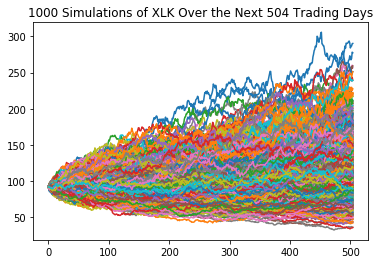

In [97]:
#Plot 1000 simulations of 504 trading days
plot_title = f"{n+1} Simulations of XLK Over the Next 504 Trading Days"
simulated_prices_XLK_df.plot(legend=None, title=plot_title)

In [98]:
# Select the last row (price of each simulation on the 504th trading day)
simulated_ending_prices_XLK = simulated_prices_XLK_df.iloc[-1, :]
simulated_ending_prices_XLK.head()

Simulation 1     78.930999
Simulation 2    110.792439
Simulation 3    184.758333
Simulation 4    105.168844
Simulation 5     97.745571
Name: 504, dtype: float64

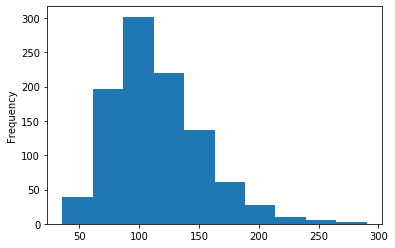

In [99]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_XLK.plot(kind='hist')

In [100]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_XLK.quantile(q=[0.025, 0.975])
confidence_interval

0.025     56.117220
0.975    204.598508
Name: 504, dtype: float64

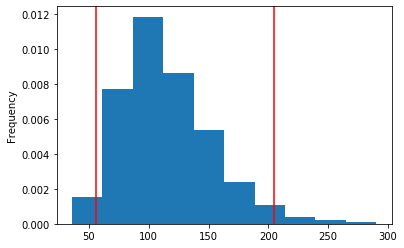

In [101]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_XLK.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [102]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - XLK_last_price) / XLK_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - XLK_last_price) / XLK_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in XLK"
      f" over the next 504 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in XLK over the next 504 trading days will end within in the range of $6111.66 and $22282.56


In [103]:
#START MONTE CARLO ANALYSIS RWR

# Calculate the mean of daily returns for RWR
avg_daily_return_rwr = concat_df.mean()['RWR_return']
print(f"The average daily return of RWR is {avg_daily_return_rwr}")

The average daily return of RWR is 0.00047992868347888543


In [104]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of XLK from DataFrame

num_trading_days = 252*2
RWR_last_price = concat_df['RWR close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_RWR_df = pd.DataFrame()

In [105]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_RWR_prices = [RWR_last_price]
    simulated_RWR_prices

    # Simulate the returns for 504 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_RWR_prices[-1] * (1 + np.random.normal(avg_daily_return_rwr, rwr_std))
        # Append the simulated price to the list
        simulated_RWR_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_RWR_df[f"Simulation {n+1}"] = pd.Series(simulated_RWR_prices)

simulated_prices_RWR_df.head()



,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,...,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000,79.100000
1,77.456296,79.159723,77.419444,77.654833,76.621638,75.448174,79.957045,79.091246,78.781238,77.946339,...,76.897149,80.129828,79.793680,79.128977,79.744344,82.546394,76.500980,79.560618,77.236823,79.551296
2,77.756082,78.072956,76.876214,75.758212,77.148489,75.559699,82.812284,78.956947,79.091660,79.203068,...,76.886333,78.649949,77.899485,80.499649,81.327083,83.547248,76.600293,81.805221,78.592067,80.971091
3,75.940275,81.141464,75.211255,74.305514,76.693569,72.390379,81.988529,79.137475,78.234854,80.417815,...,77.609592,79.639744,79.418403,78.253187,81.673926,83.380748,78.101661,78.906695,78.876641,81.736858
4,73.613626,78.863948,74.657054,73.602739,79.124784,72.618831,83.389423,79.812765,76.430940,81.057908,...,76.650971,79.561487,81.995342,79.857984,76.995953,83.003183,76.401857,79.523583,80.770818,81.790905


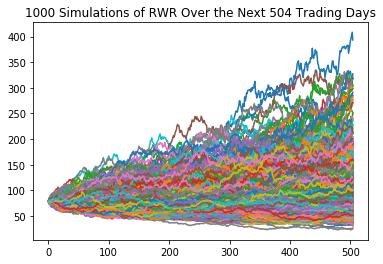

In [106]:
#Plot 1000 simulations of 504 trading days
plot_title = f"{n+1} Simulations of RWR Over the Next 504 Trading Days"
simulated_prices_RWR_df.plot(legend=None, title=plot_title)

In [107]:
# Select the last row (price of each simulation on the 504th trading day)
simulated_ending_prices_RWR = simulated_prices_RWR_df.iloc[-1, :]
simulated_ending_prices_RWR.head()

Simulation 1    101.576645
Simulation 2     99.770419
Simulation 3    135.703106
Simulation 4    187.014967
Simulation 5    129.396784
Name: 504, dtype: float64

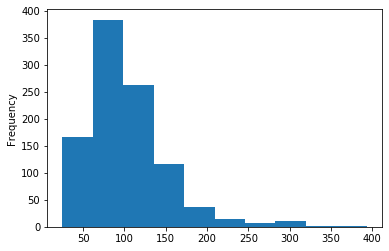

In [108]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_RWR.plot(kind='hist')

In [109]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_RWR.quantile(q=[0.025, 0.975])
confidence_interval

0.025     42.295811
0.975    227.791273
Name: 504, dtype: float64

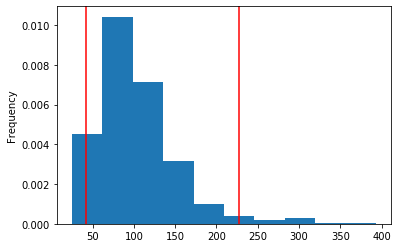

In [110]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_RWR.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [111]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - RWR_last_price) / RWR_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - RWR_last_price) / RWR_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in RWR"
      f" over the next 504 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in RWR over the next 504 trading days will end within in the range of $5347.13 and $28797.89


In [112]:
#START MONTE CARLO ANALYSIS SPY

# Calculate the mean of daily returns for SPY
avg_daily_return_spy = concat_df.mean()['SPY_return']
print(f"The average daily return of SPY is {avg_daily_return_spy}")

The average daily return of SPY is 0.00034728295560717014


In [113]:
#Set number of simulations
num_simulations = 1000

# Set number of trading days and get last closing price of SPY from DataFrame

num_trading_days = 252*2
SPY_last_price = concat_df['SPY close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_prices_SPY_df = pd.DataFrame()

In [114]:
# Run the simulation `1000` times
for n in range(num_simulations):
    
    # Initialize the simulated prices list with the last closing price of XLB
    simulated_SPY_prices = [SPY_last_price]
    simulated_SPY_prices

    # Simulate the returns for 504 days
    for i in range(num_trading_days):

    # Calculate the simulated price using the last price within the list
        simulated_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, spy_std))
        # Append the simulated price to the list
        simulated_SPY_prices.append(simulated_price)

    # Append simulated price of each simulation to DataFrame
    simulated_prices_SPY_df[f"Simulation {n+1}"] = pd.Series(simulated_SPY_prices)

simulated_prices_SPY_df.head()



,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,...,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000,293.210000
1,290.470075,302.482799,291.597017,295.008447,289.384587,297.289676,290.698845,292.169765,292.740549,291.832374,...,301.623553,288.544899,294.332442,292.624688,287.847001,297.471786,296.434877,296.154975,289.792574,294.526053
2,289.726722,306.079795,292.720416,286.075446,291.558814,293.415548,292.164844,291.101620,290.602422,291.914342,...,303.496481,289.694223,294.183636,291.554681,291.785046,295.767862,293.835373,298.682254,280.986965,287.116186
3,286.166571,308.726214,290.960122,293.813742,297.839154,288.088801,288.040408,286.193399,287.201675,284.551493,...,303.692238,290.890694,295.817474,294.473497,293.533798,295.608021,292.008948,297.592019,282.554191,287.686658
4,284.666524,304.498714,291.301915,300.072241,293.611135,289.512427,286.976337,285.754961,290.558895,282.985861,...,301.553343,283.124766,293.059112,301.508744,287.709215,293.562213,292.733265,299.537708,289.999229,293.059424


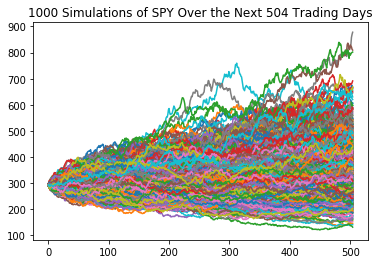

In [115]:
#Plot 1000 simulations of 504 trading days
plot_title = f"{n+1} Simulations of SPY Over the Next 504 Trading Days"
simulated_prices_SPY_df.plot(legend=None, title=plot_title)

In [116]:
# Select the last row (price of each simulation on the 504th trading day)
simulated_ending_prices_SPY = simulated_prices_SPY_df.iloc[-1, :]
simulated_ending_prices_SPY.head()

Simulation 1    377.965496
Simulation 2    377.321486
Simulation 3    223.263910
Simulation 4    369.186266
Simulation 5    496.347937
Name: 504, dtype: float64

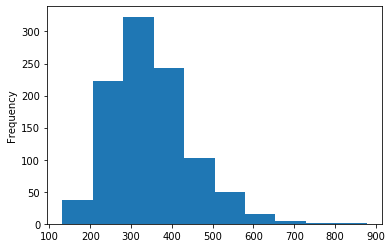

In [117]:
# Plot a frequency distribution of simulated ending prices
simulated_ending_prices_SPY.plot(kind='hist')

In [118]:
# Use `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices_SPY.quantile(q=[0.025, 0.975])
confidence_interval

0.025    198.379723
0.975    567.868873
Name: 504, dtype: float64

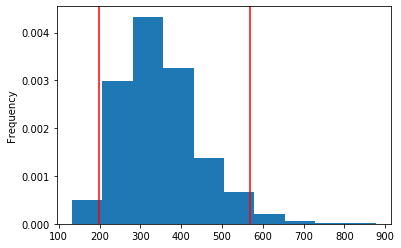

In [119]:
# Create a probability distribution histogram of simulated ending prices
# Mark the 95% confidence interval
plt.figure();
simulated_ending_prices_SPY.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [120]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - SPY_last_price) / SPY_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - SPY_last_price) / SPY_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in SPY"
      f" over the next 504 trading days will end within in the range of"
      f" ${round(ending_investment_lower_bound,2)} and ${round(ending_investment_upper_bound,2)}")

There is a 95% chance that an initial investment of $10,000 in SPY over the next 504 trading days will end within in the range of $6765.79 and $19367.31
